make: Nothing to be done for `download'.
make: Nothing to be done for `all'.
cp SRTM1.vrt SRTM1.ab111f48a127470aa0a7e6d84da1592b.vrt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin -110.5 41.0 -108.5 39.5 SRTM1.ab111f48a127470aa0a7e6d84da1592b.vrt out.tif
rm -f SRTM1.ab111f48a127470aa0a7e6d84da1592b.vrt
make: Nothing to be done for `download'.
make: Nothing to be done for `all'.
cp SRTM1.vrt SRTM1.15c6666c69a84ce38010c9980dc4a51b.vrt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin -112.5 41.5 -111.0 40.0 SRTM1.15c6666c69a84ce38010c9980dc4a51b.vrt out.tif
rm -f SRTM1.15c6666c69a84ce38010c9980dc4a51b.vrt


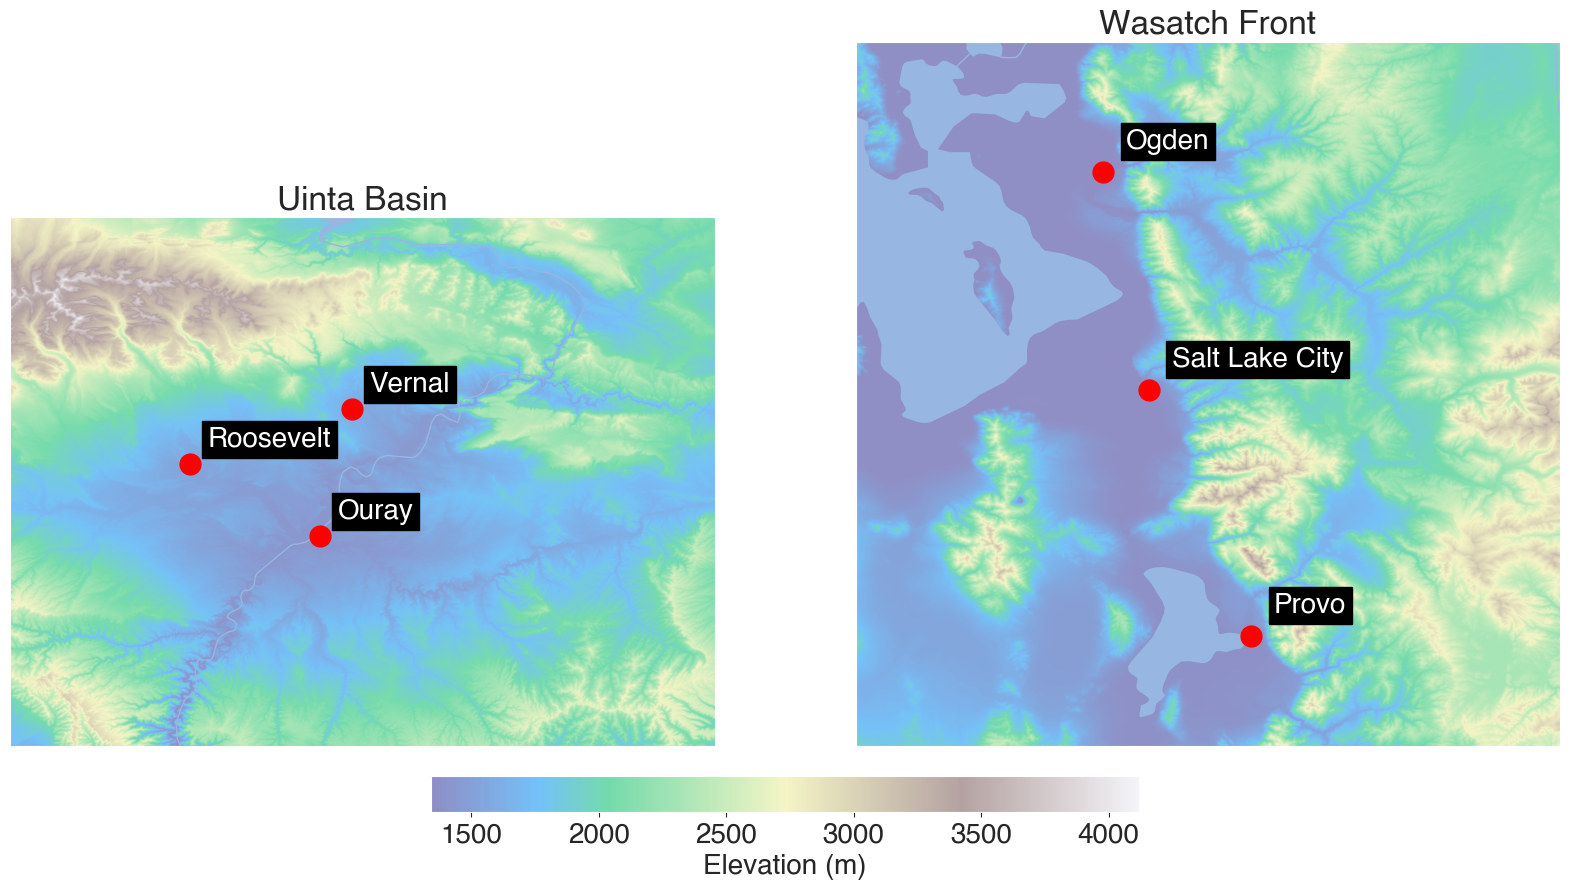

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import elevation
import rasterio
from matplotlib.colors import Normalize

plt.rcParams['font.family'] = 'Helvetica, Arial'  # This will use Helvetica if available, otherwise Arial
plt.rcParams['font.size'] = 20  # Double the default font size (default is usually 10)

def get_elevation_data(extent, resolution='SRTM1'):
    """
    Download and load elevation data for the specified extent.
    extent: (min_lon, max_lon, min_lat, max_lat)
    resolution: 'SRTM1' for 1 arc-second or 'SRTM3' for 3 arc-second resolution.
    """
    # Define the bounding box
    min_lon, max_lon, min_lat, max_lat = extent

    # Define the cache directory for elevation data
    cache_dir = 'elevation_srtm'

    # Download the elevation data
    elevation.clip(bounds=(min_lon, min_lat, max_lon, max_lat), product=resolution, cache_dir=cache_dir)

    # Load the elevation data using rasterio
    # dem_path = f'{cache_dir}/{resolution}.tif'
    dem_path = f'{cache_dir}/{resolution}/out.tif'
    with rasterio.open(dem_path) as src:
        elevation_data = src.read(1)
        transform = src.transform

    return elevation_data, transform

# Town coordinates
wasatch_towns = {
    "Salt Lake City": (40.7587, -111.8762),
    "Ogden": (41.2230, -111.9738),
    "Provo": (40.2338, -111.6585)
}

uinta_towns = {
    "Roosevelt": (40.2994, -109.9888),
    "Vernal": (40.4555, -109.5287),
    "Ouray": (40.0944, -109.6202)
}


# Set up the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10),
                               subplot_kw={'projection': ccrs.PlateCarree()})

# Define extents for the Uintah Basin and Wasatch Front
uintah_extent = [-110.5, -108.5, 39.5, 41]
wasatch_extent = [-112.5, -111, 40, 41.5]

# Get elevation data for each extent
uintah_elevation, uintah_transform = get_elevation_data(uintah_extent)
wasatch_elevation, wasatch_transform = get_elevation_data(wasatch_extent)

# Define a normalization for the color mapping of elevation
elevation_norm = Normalize(vmin=np.min(uintah_elevation), vmax=np.max(uintah_elevation))

# Plot Uintah Basin
ax1.set_extent(uintah_extent)
img1 = ax1.imshow(uintah_elevation, extent=uintah_extent, transform=ccrs.PlateCarree(), cmap='terrain', alpha=0.5, norm=elevation_norm, zorder=1)
ax1.set_title('Uinta Basin')

# Plot Wasatch Front
ax2.set_extent(wasatch_extent)
img2 = ax2.imshow(wasatch_elevation, extent=wasatch_extent, transform=ccrs.PlateCarree(), cmap='terrain', alpha=0.5, norm=elevation_norm, zorder=1)
ax2.set_title('Wasatch Front')

# Add a colorbar for elevation
cbar = plt.colorbar(img1, ax=[ax1, ax2], orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_label('Elevation (m)')

# Overlay geographic features
# Note: You'll need the specific shapefiles or use Cartopy's built-in features
for ax in [ax1, ax2]:
    ax.add_feature(cfeature.RIVERS, zorder=2)
    ax.add_feature(cfeature.LAKES, zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
    # For county borders, you might need specific shapefiles
    # ax.add_geometries(..., facecolor='none', edgecolor='black')

    # Adding town names (You'll need a shapefile or other source for town locations)
    # towns = [...] # Define your towns here
    # for town in towns:
    #     ax.text(town['lon'], town['lat'], town['name'], transform=ccrs.Geodetic())

# Annotate towns on the Uintah Basin plot with red circles and offset text
for town, (lat, lon) in uinta_towns.items():
    ax1.plot(lon, lat, 'ro', markersize=15, transform=ccrs.Geodetic(), zorder=4)  # Red circle for town location
    ax1.text(lon + 0.05, lat + 0.05, town, transform=ccrs.Geodetic(), zorder=5, color='white', backgroundcolor='black')

# Annotate towns on the Wasatch Front plot with red circles and offset text
for town, (lat, lon) in wasatch_towns.items():
    ax2.plot(lon, lat, 'ro', markersize=15, transform=ccrs.Geodetic(), zorder=4)  # Red circle for town location
    ax2.text(lon + 0.05, lat + 0.05, town, transform=ccrs.Geodetic(), zorder=5, color='white', backgroundcolor='black')


plt.show()
